In [81]:
import kagglehub
import pandas as pd
import os

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

path = kagglehub.dataset_download("bryanchungweather/nba-player-stats-dataset-for-the-2023-2024")

print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in dataset:", files)

csv_path = os.path.join(path, files[0])

df = pd.read_csv(csv_path)
print(df.head(10))

Using Colab cache for faster access to the 'nba-player-stats-dataset-for-the-2023-2024' dataset.
Path to dataset files: /kaggle/input/nba-player-stats-dataset-for-the-2023-2024
Files in dataset: ['NBA_2024_per_game(26-01-2024).csv', 'NBA_2024_per_game(13-11-2023 Updated).csv', 'NBA_2024_per_game(04-12-2023).csv', 'NBA_2024_per_game(22-11-2023).csv', 'NBA_2024_per_game(15-11-2023 Updated).csv', 'NBA_2024_per_game(03-01-2024).csv', 'NBA_2024_per_game(28-11-2023).csv', 'NBA_2024_per_game(05-12-2023).csv', 'NBA_2024_per_game(20-11-2023).csv', 'NBA_2024_per_game(27-12-2023).csv', 'NBA_2024_per_game(17-11-2023).csv']
                     Player   Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  \
0          Precious Achiuwa  C-PF   24  TOT  37   0  16.2  2.8   5.8  0.479   
1          Precious Achiuwa     C   24  TOR  25   0  17.5  3.1   6.8  0.459   
2          Precious Achiuwa    PF   24  NYK  12   0  13.7  2.0   3.6  0.558   
3               Bam Adebayo     C   26  MIA  34  34  35.1  7.8  1

In [82]:
 #Ensure no duplicate players
def collapse_player(group):
    tot_rows = group[group["Tm"] == "TOT"]
    if len(tot_rows) > 0:
        return tot_rows.iloc[0]
    return group.iloc[0]

df = (
    df.groupby("Player", as_index=False)
      .apply(collapse_player)
      .reset_index(drop=True)
)

df = df.drop_duplicates(subset=["Player"])

/tmp/ipython-input-1917031378.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(collapse_player)


In [60]:
df = df[(df["G"] >= 20) & (df["MP"] >= 15)]

In [61]:
feature_cols = [
    "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA",
    "2P%", "eFG%", "FT", "FTA", "FT%", "TRB", "AST",
    "STL", "BLK", "TOV", "PF", "PTS"
]

In [62]:
df_clean = df.dropna(subset=feature_cols).copy()
X = df_clean[feature_cols].to_numpy()

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sanity checks
print("Rows in df_clean:", len(df_clean))
print("Rows in X_scaled:", X_scaled.shape[0])

Rows in df_clean: 278
Rows in X_scaled: 278


In [71]:
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    model = AgglomerativeClustering(
        n_clusters=k,
        metric="euclidean",
        linkage="ward"
    )
    labels = model.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append((k, sil))

print("\nSilhouette Scores (k, score):")
for k, score in sil_scores:
    print(k, round(score, 4))


Silhouette Scores (k, score):
2 0.266
3 0.265
4 0.1291
5 0.134
6 0.1072
7 0.1014
8 0.1083
9 0.0932
10 0.0929


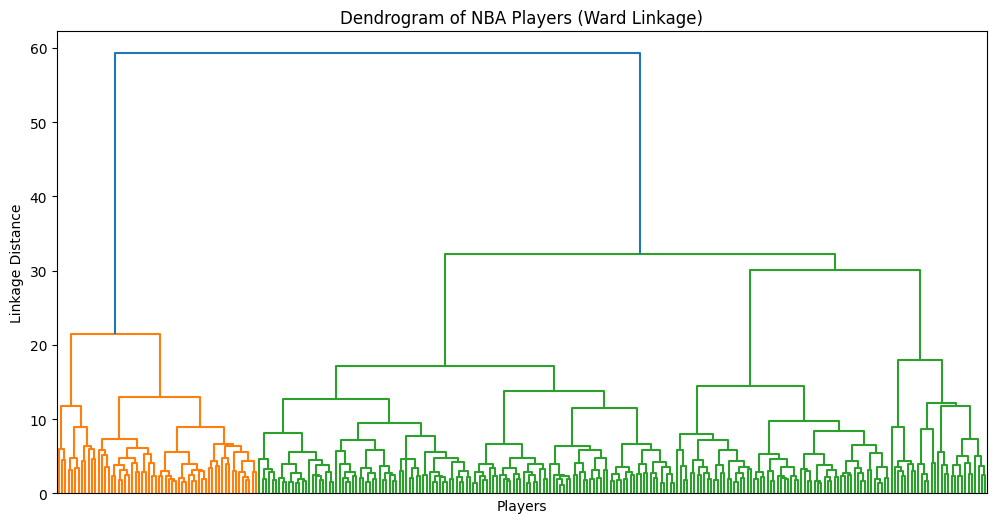

In [65]:
# Dendrogram of NBA Players

Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, no_labels=True)
plt.title("Dendrogram of NBA Players (Ward Linkage)")
plt.xlabel("Players")
plt.ylabel("Linkage Distance")
plt.show()

In [83]:
k_chosen = 5

model = AgglomerativeClustering(
    n_clusters=k_chosen,
    metric="euclidean",
    linkage="ward"
)

labels = model.fit_predict(X_scaled)

df_clean["cluster"] = labels

cluster_means = df_clean.groupby("cluster")[feature_cols].mean()
print("Cluster Means\n")
print(cluster_means)

Cluster Means

                MP        FG        FGA       FG%        3P       3PA  \
cluster                                                                 
0        27.317045  4.429545   9.745455  0.454045  1.703409  4.531818   
1        19.433333  2.669792   5.811458  0.461146  1.063542  2.852083   
2        33.820690  7.867241  16.894828  0.464345  2.386207  6.377586   
3        27.575000  5.196429   9.600000  0.558214  0.742857  2.207143   
4        34.062500  9.562500  16.937500  0.566250  0.512500  1.587500   

              3P%        2P        2PA       2P%  ...        FT       FTA  \
cluster                                           ...                       
0        0.363682  2.734091   5.207955  0.524000  ...  1.598864  2.013636   
1        0.370875  1.598958   2.956250  0.543271  ...  0.871875  1.133333   
2        0.371931  5.477586  10.515517  0.518672  ...  4.113793  4.927586   
3        0.257643  4.457143   7.403571  0.608143  ...  2.225000  2.985714   
4        0.

In [79]:
print("\n== Example Players in Each Cluster ==\n")
for c in range(k_chosen):
    print(f"\n- Cluster {c} -")
    print(df_clean[df_clean["cluster"] == c]["Player"].head(10).to_string(index=False))


== Example Players in Each Cluster ==


- Cluster 0 -
      Aaron Gordon
     Aaron Nesmith
        Alec Burks
       Alex Caruso
     Amen Thompson
    Andrew Wiggins
    Ausar Thompson
     Austin Reaves
Bennedict Mathurin
   Bilal Coulibaly

- Cluster 1 -
  Aaron Holiday
     Al Horford
    Amir Coffey
Andrew Nembhard
  Anthony Black
    Ayo Dosunmu
   Bobby Portis
 Bryce McGowens
  Caleb Houstan
    Cam Reddish

- Cluster 2 -
 Anfernee Simons
 Anthony Edwards
Bojan Bogdanović
  Brandon Ingram
  Brandon Miller
     CJ McCollum
 Cade Cunningham
      Cam Thomas
      Coby White
  Damian Lillard

- Cluster 3 -
    Andre Drummond
       Brook Lopez
     Chet Holmgren
    Day'Ron Sharpe
  Dereck Lively II
       Evan Mobley
      Goga Bitadze
Isaiah Hartenstein
    Isaiah Stewart
  Jabari Smith Jr.

- Cluster 4 -
       Alperen Şengün
        Anthony Davis
          Bam Adebayo
     Domantas Sabonis
Giannis Antetokounmpo
          Joel Embiid
         Nikola Jokić
      Zion Williamson